# Model evaluation

In [90]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from src.support.data_transformation import FileHandler
import src.support.data_visualization as dv
import plotly.express as px

from xgboost import XGBClassifier

- Inspect for columns to drop
    - From OHLCV he leaves only volume to generate ln(Volume). I will have both to analyze the impact.
    - He drops all categoricals, OHLCV and 'Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'.
- Differentiates categorical
- Differentiates custom from tech ind
- Checks the differences in date ranges for symbols. He truncates to start from 2000 (I doubt how much sense that makes)
- Generates dummies for categoricals. I wonder if I should do that for different months or if I should use cycle features. Some months might be important. Also weekdays, etc.
    He says to generate combinations between months and weekdays?
- Generate dummies for tickers. For the all together model is necessary, but I think I should use a different encoding, like hash.
- For this model, feature selection is going to be key.
- Determine targets (for him ['growth_future_5d', 'is_positive_growth_5d_future'])
- Train/val/test split
- "Rule" prediction strategies

Then... EDA
- He performs correlation Analysis


TO-DO:
- [ ] Add fees
Fixed Pricing:

A fixed commission of $0.005 per share.
Minimum commission per order: $1.00.
Maximum commission per order: 1% of the trade value.
Example: For an order of 100 shares at $25 per share, the commission would be $0.50 (100 shares x $0.005), but since the minimum is $1.00, you'd be charged $1.00.

# 1. Introduction and purpose

## 1st approach - general purpose (all stocks) single point prediction: 7d growth regression and classification

### Data import

In [91]:
general_df = pd.read_parquet("../data/transformed/dataset.parquet")

In [92]:
general_df.info()
general_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226954 entries, 0 to 226953
Columns: 213 entries, close to BTC_growth_adj_365d
dtypes: datetime64[ns, UTC](4), datetime64[ns](2), float64(132), int32(66), int64(3), object(6)
memory usage: 311.7+ MB


close      high       low      open        volume symbol        country  \
0  0.059827  0.062498  0.054485  0.054485  1.031789e+09   MSFT  united_states   
1  0.061963  0.063032  0.059827  0.059827  3.081600e+08   MSFT  united_states   
2  0.063032  0.063566  0.061963  0.061963  1.331712e+08   MSFT  united_states   

       region                 industry      sector  ...  \
0  US_AMERICA  software-infrastructure  technology  ...   
1  US_AMERICA  software-infrastructure  technology  ...   
2  US_AMERICA  software-infrastructure  technology  ...   

  brent_oil_growth_adj_7d  brent_oil_growth_adj_30d  brent_oil_growth_adj_90d  \
0                     NaN                       NaN                       NaN   
1                     NaN                       NaN                       NaN   
2                     NaN                       NaN                       NaN   

   brent_oil_growth_adj_365d  BTC_growth_adj_1d BTC_growth_adj_3d  \
0                        NaN                NaN               NaN   
1                        NaN                NaN               NaN   
2                        NaN                NaN               NaN   

  BTC_growth_adj_7d BTC_growth_adj_30d  BTC_growth_adj_90d  \
0               NaN                NaN                 NaN   
1               NaN                NaN                 NaN   
2               NaN                NaN                 NaN   

   BTC_growth_adj_365d  
0                  NaN  
1                  NaN  
2                  NaN  

[3 rows x 213 columns]

Data types seem mostly correct and are convenient. Almost all are numerical except for a few datetimes, as it is to be expected and one object type, "symbol". The symbol is of course important and it will be necessary to perform some kind of encoding to make it ingestible for the model.

**Symbols dates and truncate dataset**

Let's now inspec the different time segments of activity for each symbol.

In [93]:
general_df.groupby(['symbol'])['date'].agg(['min','max','count'])

min                       max  count
symbol                                                                  
AAPL          1980-12-12 00:00:00+00:00 2025-01-17 00:00:00+00:00  11116
ACN           2001-07-19 00:00:00+00:00 2025-01-17 00:00:00+00:00   5911
AMZN          1997-05-15 00:00:00+00:00 2025-01-17 00:00:00+00:00   6964
ASML          1995-03-15 00:00:00+00:00 2025-01-17 00:00:00+00:00   7513
AVGO          2009-08-06 00:00:00+00:00 2025-01-17 00:00:00+00:00   3888
BHARTIARTL.NS 2002-07-01 00:00:00+00:00 2025-01-20 00:00:00+00:00   5600
BRK-B         1996-05-09 00:00:00+00:00 2025-01-17 00:00:00+00:00   7221
CDI.PA        1992-01-27 00:00:00+00:00 2025-01-20 00:00:00+00:00   8509
GOOG          2004-08-19 00:00:00+00:00 2025-01-17 00:00:00+00:00   5138
HDB           2001-07-20 00:00:00+00:00 2025-01-17 00:00:00+00:00   5910
HINDUNILVR.NS 1996-01-01 00:00:00+00:00 2025-01-20 00:00:00+00:00   7298
IBN           2000-03-28 00:00:00+00:00 2025-01-17 00:00:00+00:00   6241
IDEXY         2010-01-20 00:00:00+00:00 2025-01-17 00:00:00+00:00   3774
INFY          1999-03-11 00:00:00+00:00 2025-01-17 00:00:00+00:00   6506
ITC.NS        1996-01-01 00:00:00+00:00 2025-01-20 00:00:00+00:00   7295
JPM           1980-03-17 00:00:00+00:00 2025-01-17 00:00:00+00:00  11304
LICI.NS       2022-05-17 00:00:00+00:00 2025-01-20 00:00:00+00:00    663
LLY           1972-06-01 00:00:00+00:00 2025-01-17 00:00:00+00:00  13270
LT.NS         2002-07-01 00:00:00+00:00 2025-01-20 00:00:00+00:00   5603
MC.PA         2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6439
META          2012-05-18 00:00:00+00:00 2025-01-17 00:00:00+00:00   3186
MSFT          1986-03-13 00:00:00+00:00 2025-01-21 00:00:00+00:00   9791
NVDA          1999-01-22 00:00:00+00:00 2025-01-17 00:00:00+00:00   6539
NVO           1981-04-30 00:00:00+00:00 2025-01-17 00:00:00+00:00  11021
OR.PA         2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6439
RELIANCE.NS   1996-01-01 00:00:00+00:00 2025-01-20 00:00:00+00:00   7295
RMS.PA        2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6439
SAP           1995-09-18 00:00:00+00:00 2025-01-17 00:00:00+00:00   7384
SBIN.NS       1996-01-01 00:00:00+00:00 2025-01-20 00:00:00+00:00   7296
SIE.DE        1996-11-08 00:00:00+00:00 2025-01-20 00:00:00+00:00   7225
TCS.NS        2002-08-12 00:00:00+00:00 2025-01-20 00:00:00+00:00   5571
TTE           1991-10-25 00:00:00+00:00 2025-01-17 00:00:00+00:00   8368
V             2008-03-19 00:00:00+00:00 2025-01-17 00:00:00+00:00   4237

The fact that these dates are different mean that their IPOs dates are also different, meaning that they got into the stocks market sooner or later than the others. It is also a good sign, showing that other indices or macroindicators introduced do not broadcast their dates and joins were correct.

To feed the least sparse dataset possible to the model, let us truncate it to start from 2000-01-01.

In [94]:
general_df = general_df[general_df.loc[:,"date"] >= "2000-01-01"]

Now we can observe the truncated ranges from the different symbols. Most stocks will start at 2000-01-01, while others with the latest IPOs will have dates closest to present day.

In [95]:
general_df.groupby(['symbol'])['date'].agg(['min','max','count'])

min                       max  count
symbol                                                                  
AAPL          2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
ACN           2001-07-19 00:00:00+00:00 2025-01-17 00:00:00+00:00   5911
AMZN          2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
ASML          2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
AVGO          2009-08-06 00:00:00+00:00 2025-01-17 00:00:00+00:00   3888
BHARTIARTL.NS 2002-07-01 00:00:00+00:00 2025-01-20 00:00:00+00:00   5600
BRK-B         2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
CDI.PA        2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6439
GOOG          2004-08-19 00:00:00+00:00 2025-01-17 00:00:00+00:00   5138
HDB           2001-07-20 00:00:00+00:00 2025-01-17 00:00:00+00:00   5910
HINDUNILVR.NS 2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6253
IBN           2000-03-28 00:00:00+00:00 2025-01-17 00:00:00+00:00   6241
IDEXY         2010-01-20 00:00:00+00:00 2025-01-17 00:00:00+00:00   3774
INFY          2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
ITC.NS        2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6250
JPM           2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
LICI.NS       2022-05-17 00:00:00+00:00 2025-01-20 00:00:00+00:00    663
LLY           2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
LT.NS         2002-07-01 00:00:00+00:00 2025-01-20 00:00:00+00:00   5603
MC.PA         2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6439
META          2012-05-18 00:00:00+00:00 2025-01-17 00:00:00+00:00   3186
MSFT          2000-01-03 00:00:00+00:00 2025-01-21 00:00:00+00:00   6301
NVDA          2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
NVO           2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
OR.PA         2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6439
RELIANCE.NS   2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6250
RMS.PA        2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6439
SAP           2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
SBIN.NS       2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6251
SIE.DE        2000-01-03 00:00:00+00:00 2025-01-20 00:00:00+00:00   6404
TCS.NS        2002-08-12 00:00:00+00:00 2025-01-20 00:00:00+00:00   5571
TTE           2000-01-03 00:00:00+00:00 2025-01-17 00:00:00+00:00   6300
V             2008-03-19 00:00:00+00:00 2025-01-17 00:00:00+00:00   4237

**Numerical descriptive summary**

Let us observe data ranges for numerical features to make sure there are no unusual data that could affect model predictions.

Starting from the OHLCV data for each symbol and the lag features generated for the first approach:

In [96]:
general_df.describe().T.head(24)

count                           mean  \
close                      188487.0                     199.602213   
high                       188487.0                     201.815486   
low                        188487.0                     197.396387   
open                       188487.0                     199.672024   
volume                     188487.0                48545399.005772   
year                       188487.0                    2012.659733   
month                      188487.0                        6.54234   
weekday                    188487.0                       2.013391   
quarter_n                  188487.0                       2.514184   
quarter                      188487  2013-01-13 19:47:34.891849216   
month_dt                     188487  2013-02-13 08:01:27.551926784   
growth_adj_1d              188472.0                       1.000871   
growth_adj_3d              188442.0                       1.002548   
growth_adj_7d              188412.0                         1.0042   
growth_adj_30d             188157.0                       1.018219   
growth_adj_90d             187497.0                       1.055763   
growth_adj_365d            184648.0                       1.240153   
SMA10                      188352.0                     199.138698   
SMA20                      188202.0                     198.626405   
is_growing_moving_average  188487.0                       0.574687   
high_minus_low_relative    188487.0                       0.024625   
30d_volatility             188052.0                     106.046332   
growth_adj_future_7d       188322.0                       1.001748   
is_positive_growth_7d      188487.0                       0.543836   

                                           min                  25%  \
close                                 0.056325            17.440497   
high                                  0.060222             17.63034   
low                                   0.055025            17.197172   
open                                  0.055789            17.420001   
volume                                     0.0            1230000.0   
year                                    2000.0               2007.0   
month                                      1.0                  4.0   
weekday                                    0.0                  1.0   
quarter_n                                  1.0                  2.0   
quarter                    2000-01-01 00:00:00  2007-01-01 00:00:00   
month_dt                   2000-01-01 00:00:00  2007-03-01 00:00:00   
growth_adj_1d                         0.230055             0.990698   
growth_adj_3d                         0.242517             0.984277   
growth_adj_7d                          0.23851             0.980313   
growth_adj_30d                        0.231445             0.964974   
growth_adj_90d                        0.225615             0.957956   
growth_adj_365d                       0.130272             0.986747   
SMA10                                 0.062843            17.420493   
SMA20                                 0.065717            17.422264   
is_growing_moving_average                  0.0                  0.0   
high_minus_low_relative                    0.0             0.013377   
30d_volatility                             0.0             8.698695   
growth_adj_future_7d                 -2.192693             0.979926   
is_positive_growth_7d                      0.0                  0.0   

                                           50%                  75%  \
close                                51.073063           177.037498   
high                                 51.606434           179.125747   
low                                  50.438348                175.0   
open                                 51.019744           177.196888   
volume                               3935820.0           18223813.0   
year                                    2013.0               2019.0   
month 

Data ranges seem normal. As there are many symbols mixed in here, it is difficult to draw any conclusions. We will leave that for later.

Continuing with the next set of features, we can inspect the ranges of momentum indicators.

In [97]:
general_df.describe().T.iloc[24:63,:]

count        mean         min        25%  \
growth_adj_future_30d   187761.0    1.008029   -2.320678   0.963701   
is_positive_growth_30d  188487.0    0.581961         0.0        0.0   
adx                     188082.0   23.968091     4.22858  16.740494   
adxr                    187887.0   23.969565    5.124484  17.578299   
apo                     188112.0    0.862763 -175.047542   -0.42273   
aroon_1                 188277.0   43.803052         0.0   7.142857   
aroon_2                 188277.0   54.291777         0.0  21.428571   
aroonosc                188277.0   10.488725      -100.0      -50.0   
bop                     188487.0    0.006324   -4.326922  -0.454549   
cci                     188292.0   14.865401 -466.666667 -70.550204   
cmo                     188277.0    6.016913  -89.353568 -10.691182   
dx                      188277.0   23.959327    0.000092  10.024688   
macd                    187992.0    0.867041  -117.90646  -0.237089   
macdsignal              187992.0    0.866803  -99.444153  -0.212546   
macdhist                187992.0    0.000238  -44.261174   -0.15627   
macd_ext                187992.0    0.866046 -175.047542  -0.422604   
macdsignal_ext          187992.0    0.868879 -154.246351  -0.389738   
macdhist_ext            187992.0   -0.002833 -111.363309  -0.349855   
macd_fix                187992.0    0.825694 -112.036725  -0.225736   
macdsignal_fix          187992.0    0.825414  -94.699915  -0.202798   
macdhist_fix            187992.0     0.00028  -41.925462  -0.148465   
mfi                     188277.0   52.790389        -0.0  41.181984   
minus_di                188292.0    14.32165         0.0    1.20287   
mom                     188337.0    1.228881 -408.584229  -0.978345   
plus_di                 188277.0   25.307307    1.816527  19.216996   
dm                      188292.0   15.543702         0.0   1.383081   
ppo                     188112.0    0.424661  -45.120093  -1.225965   
roc                     188337.0    0.828715  -76.528402  -2.624636   
rocp                    188337.0    0.008287   -0.765284  -0.026246   
rocr                    188337.0    1.008287    0.234716   0.973754   
rocr100                 188337.0  100.828715   23.471598  97.375364   
rsi                     188277.0    52.99624         0.0  44.644869   
slowk                   188367.0   53.340751  -16.877607  31.678052   
slowd                   188367.0    53.33761  -10.372827  33.605328   
fastk                   188397.0    53.34212 -113.072112   25.52633   
fastd                   188397.0   53.338476  -16.877607  31.677271   
fastk_rsi               188187.0   51.042435         0.0        0.0   
fastd_rsi               188187.0    51.03719        -0.0  21.703429   
trix                    187167.0    0.061499   -1.625692  -0.052392   

                               50%         75%         max         std  
growth_adj_future_30d     1.015912    1.064043    1.794084    0.103521  
is_positive_growth_30d         1.0         1.0         1.0    0.493238  
adx                       21.89167   29.166306   78.010724    9.811934  
adxr                     22.222628   28.560898   73.911043    8.827359  
apo                       0.091935    1.132882  191.909064   11.309168  
aroon_1                  35.714286   78.571429       100.0   36.118556  
aroon_2                  57.142857   92.857143       100.0   36.467061  
aroonosc                 28.571429   64.285714       100.0   63.487772  
bop                            0.0    0.467533     2.54903    0.531462  
cci                      25.904889   98.052746  466.666667  108.182054  
cmo                       6.143003   22.881578       100.0   23.909957  
dx                       21.048594   34.951216       100.0   17.039761  
macd                      0.098756    0.915832   129.75188    7.944941  
macdsignal                0.100039    0.883175  117.422158    7.444814  
macdhist                  0.000518    0.163609   43.244011    2.470077  
macd_ext          

These momentum indicators can have negative values so nothing concerning is seen in these values.

Next, Volume/Volatility/Cycle indicators. Again, same as above, all ranges are normal.

In [98]:
general_df.describe().T.iloc[63:79,:]

count                mean                 min  \
ultosc                188067.0           51.560374                 0.0   
willr                 188292.0          -44.522624         -121.839013   
ad                    188487.0   2153089828.878305 -53108809045.536186   
adosc                 188352.0      3819754.915672    -3373806477.8666   
obv                   188487.0  11503529041.817558      -32880852000.0   
atr                   188277.0            4.692809                 0.0   
natr                  188277.0             2.74216                 0.0   
ht_dcperiod           188007.0           22.202664           10.027399   
ht_dcphase            187542.0          134.318026          -44.996577   
ht_phasor_inphase     188007.0            0.501951          -318.18086   
ht_phasor_quadrature  188007.0            0.000294         -794.621067   
ht_sine_sine          187542.0           -0.027099                -1.0   
ht_sine_leadsine      187542.0           -0.124125                -1.0   
ht_trendmod           188487.0            0.799774                 0.0   
avgprice              188487.0          199.621528            0.057108   
medprice              188487.0          199.605937            0.057776   

                                  25%               50%               75%  \
ultosc                      44.505974         51.649226         58.709879   
willr                      -71.447699        -41.208958        -16.608526   
ad                    11831591.186232  264023547.076309  1130913179.43348   
adosc                 -1260171.186899      99812.801748    2267992.228574   
obv                        91190752.5       552141200.0      5810560415.0   
atr                          0.404765          1.160243          4.236774   
natr                         1.801918          2.322773          3.170759   
ht_dcperiod                 18.234133         21.270665         25.199034   
ht_dcphase                  37.735212        163.011019        205.311416   
ht_phasor_inphase           -0.568276          0.039635           0.98828   
ht_phasor_quadrature        -1.065475         -0.002039          1.045514   
ht_sine_sine                -0.507848         -0.045879          0.444786   
ht_sine_leadsine            -0.832409          -0.33872          0.661733   
ht_trendmod                       1.0               1.0               1.0   
avgprice                     17.44005         51.044078        177.129782   
medprice                    17.421624         51.039134        177.107932   

                                     max                 std  
ultosc                         97.311852           10.408336  
willr                          21.296016           30.318158  
ad                    69992286484.822159  10959192811.155628  
adosc                  4301688717.780766    110981450.681209  
obv                       169848641200.0  29204602747.721458  
atr                           135.663055            9.745055  
natr                           48.270341            1.568629  
ht_dcperiod                    48.983553            5.386444  
ht_dcphase                     314.99929           96.641996  
ht_phasor_inphase             305.676141           12.790996  
ht_phasor_quadrature          739.763358           19.598317  
ht_sine_sine                         1.0            0.592108  
ht_sine_leadsine                     1.0            0.734825  
ht_trendmod                          1.0             0.40017  
avgprice                     4527.401783          440.740301  
medprice                     4528.135787          440.726655

Inspecting the last group of indicators, let's look at the pattern recognition indicators.

In [99]:
pd.set_option("display.max_rows",61)
general_df.describe().T.iloc[79:140,:]

count        mean       min        25%        50%  \
typprice             188487.0  199.604696  0.057292   17.43921  51.038747   
wclprice             188487.0  199.604075   0.05705  17.440608  51.050001   
cdl2crows            188487.0   -0.101864    -100.0        0.0        0.0   
cdl3blackrows        188487.0   -0.015916    -100.0        0.0        0.0   
cdl3inside           188487.0    0.261556    -100.0        0.0        0.0   
cdl3linestrike       188487.0    0.004775    -100.0        0.0        0.0   
cdl3outside          188487.0   -0.341138    -100.0        0.0        0.0   
cdl3starsinsouth     188487.0         0.0       0.0        0.0        0.0   
cdl3whitesoldiers    188487.0    0.042443       0.0        0.0        0.0   
cdlabandonedbaby     188487.0    0.001592    -100.0        0.0        0.0   
cdladvancedblock     188487.0   -0.443001    -100.0        0.0        0.0   
cdlbelthold          188487.0   -0.156509    -100.0        0.0        0.0   
cdlbreakaway         188487.0    -0.01008    -100.0        0.0        0.0   
cdlclosingmarubozu   188487.0    1.237221    -100.0        0.0        0.0   
cdlconcealbabyswall  188487.0         0.0       0.0        0.0        0.0   
cdlcounterattack     188487.0    0.001061    -100.0        0.0        0.0   
cdldarkcloudcover    188487.0   -1.604355    -100.0        0.0        0.0   
cdldoji              188487.0   13.928282       0.0        0.0        0.0   
cdldojistar          188487.0    -0.34326    -100.0        0.0        0.0   
cdldragonflydoji     188487.0    1.425032       0.0        0.0        0.0   
cdlengulfing         188487.0   -0.938526    -100.0        0.0        0.0   
cdleveningdojistar   188487.0   -0.229194    -100.0        0.0        0.0   
cdleveningstar       188487.0   -0.691825    -100.0        0.0        0.0   
cdlgapsidesidewhite  188487.0    0.116719    -100.0        0.0        0.0   
cdlgravestonedoji    188487.0    1.188941       0.0        0.0        0.0   
cdlhammer            188487.0    2.022951       0.0        0.0        0.0   
cdlhangingman        188487.0   -2.113674    -100.0        0.0        0.0   
cdlharami            188487.0    0.740635    -100.0        0.0        0.0   
cdlharamicross       188487.0    0.215399    -100.0        0.0        0.0   
cdlhighwave          188487.0    0.875392    -100.0        0.0        0.0   
cdlhikkake           188487.0   -0.430268    -200.0        0.0        0.0   
cdlhikkakemod        188487.0   -0.016977    -200.0        0.0        0.0   
cdlhomingpigeon      188487.0    1.481269       0.0        0.0        0.0   
cdlidentical3crows   188487.0   -0.003714    -100.0        0.0        0.0   
cdlinneck            188487.0   -0.135818    -100.0        0.0        0.0   
cdlinvertedhammer    188487.0    1.350226       0.0        0.0        0.0   
cdlkicking           188487.0   -0.002122    -100.0        0.0        0.0   
cdlkickingbylength   188487.0   -0.003183    -100.0        0.0        0.0   
cdlladderbottom      188487.0    0.179853       0.0        0.0        0.0   
cdllongleggeddoji    188487.0   13.526662       0.0        0.0        0.0   
cdllongline          188487.0    0.789444    -100.0        0.0        0.0   
cdlmarubozu          188487.0    0.422841    -100.0        0.0        0.0   
cdlmatchinglow       188487.0    1.614965       0.0        0.0        0.0   
cdlmathold           188487.0         0.0       0.0        0.0        0.0   
cdlmorningdojistar   188487.0    0.198953       0.0        0.0        0.0   
cdlmorningstar       188487.0    0.600041       0.0        0.0        0.0   
cdlonneck            188487.0   -0.261556    -100.0        0.0        0.0   
cdlpiercing          188487.0    0.338485       0.0        0.0        0.0   
cdlrickshawman       188487.0    9.982121       0.0        0.0        0.0   
cdlrisefall3methods  188487.0    0.004244    -100.0        0.0        0.0   
cdlseparatinglines   188487.0    0.034485    -100.0        0.0        0.0   
cdlshootingstar     

In [100]:
pd.set_option("display.max_rows",63)
general_df.describe().T.iloc[140:,:]

count        mean       min       25%       50%  \
cdlupsidegap2crows         188487.0    -0.06844    -100.0       0.0       0.0   
cdlxsidegap3methods        188487.0   -0.024935    -100.0       0.0       0.0   
^GSPC_growth_adj_1d        186234.0    1.000313  0.880159  0.995352  1.000636   
^GSPC_growth_adj_3d        186234.0    1.000924  0.860941  0.991993  1.002217   
^GSPC_growth_adj_7d        186234.0    1.001552  0.816599  0.990212  1.003151   
^GSPC_growth_adj_30d       186234.0    1.006836  0.663281  0.983756  1.013293   
^GSPC_growth_adj_90d       186234.0    1.020504  0.594021  0.982516  1.032911   
^GSPC_growth_adj_365d      186234.0    1.078871  0.511772  1.003445  1.105993   
^DJI_growth_adj_1d         186234.0    1.000284  0.870735  0.995507  1.000512   
^DJI_growth_adj_3d         186234.0    1.000848  0.857145  0.992368  1.001894   
^DJI_growth_adj_7d         186234.0    1.001422  0.811623  0.990236  1.002979   
^DJI_growth_adj_30d        186234.0    1.006257  0.636275  0.983465   1.01154   
^DJI_growth_adj_90d        186234.0    1.018674   0.65845   0.98252  1.026068   
^DJI_growth_adj_365d       186234.0    1.070591  0.538102  0.998831  1.079152   
^GDAXI_growth_adj_1d       185384.0    1.000271  0.877614  0.993898   1.00076   
^GDAXI_growth_adj_3d       185384.0     1.00086  0.837486  0.989336  1.002146   
^GDAXI_growth_adj_7d       185384.0    1.001453  0.766961  0.986482  1.003556   
^GDAXI_growth_adj_30d      185384.0    1.006586  0.612433  0.974545  1.011918   
^GDAXI_growth_adj_90d      185384.0    1.019766  0.590251  0.964353  1.030385   
^GDAXI_growth_adj_365d     185384.0     1.07727  0.419932   0.92501  1.125085   
EPI_growth_adj_1d          133046.0    1.000299  0.869565  0.992647   1.00083   
EPI_growth_adj_3d          132990.0    1.000884   0.83224  0.986911  1.001882   
EPI_growth_adj_7d          132934.0    1.001542  0.781147  0.983454  1.003074   
EPI_growth_adj_30d         132471.0     1.00786  0.549279  0.965391  1.010772   
EPI_growth_adj_90d         131228.0    1.024819  0.456612  0.948664  1.026471   
EPI_growth_adj_365d        125918.0    1.119421  0.368391  0.924444  1.055724   
gdppot_us_yoy              188487.0    0.021218   0.01404   0.01846  0.019874   
gdppot_us_qoq              188487.0    0.005192  0.003427   0.00455  0.004952   
CPILFESL                   188487.0  237.810662     178.7   209.135   232.832   
cpi_core_yoy_prev_month    188487.0    0.024082  0.006027  0.017417  0.021382   
cpi_core_mom_prev_month    188487.0    0.001995 -0.004763  0.001167  0.001864   
FEDFUNDS_prev_month        188487.0    1.833205      0.05      0.14      1.15   
eur_yld_Y1_prev_2d         157034.0    0.859449  -0.91298  -0.62767    0.1093   
eur_yld_Y10_prev_2d        157034.0    1.895582  -0.81522   0.40958  2.038775   
eur_yld_Y5_prev_2d         157034.0    1.307059  -0.99622  -0.25136    1.0062   
DGS1_prev_1d               180608.0    1.944447      0.04      0.25      1.32   
DGS5_prev_1d               180608.0    2.632158      0.19      1.49      2.43   
DGS10_prev_1d              180608.0     3.18934      0.52      2.16      3.06   
VIX_close                  186247.0   19.685695      9.14     13.79     17.58   
gold_growth_adj_1d         182066.0    1.000424  0.906462  0.995284  1.000471   
gold_growth_adj_3d         182022.0    1.001263  0.873131  0.990909  1.001517   
gold_growth_adj_7d         181978.0    1.002109  0.865522  0.988439   1.00271   
gold_growth_adj_30d        181604.0    1.009138  0.781467  0.978775  1.006712   
gold_growth_adj_90d        180636.0    1.027334  0.752426  0.974994   1.02481   
gold_growth_adj_365d       176483.0    1.106855  0.709403  0.988745  1.097191   
crude_oil_growth_adj_1d    182292.0     0.99981 -2.059661  0.987475  1.001084   
crude_oil_growth_adj_3d    182248.0    1.000624  -1.89381  0.977659  1.002638   
crude_oil_growth_adj_7d    182204.0    1.001641 -1.679161  0.972572  1.004092   
crude_oil_growth_adj_30d   181830.0    1.008876 -1.847324  0.

**Duplicated data**

To look for duplicates, let's see if there are duplicated records for symbol and date.

In [101]:
print(f"There are {int(general_df.duplicated(subset=['symbol','date']).sum())} duplicated records.")

There are 0 duplicated records.


**Missing values**

Now lets look for missing values. Growth values are excluded from this check as they are inherently missing at the beginning of each symbol time series due to their lagged nature. Imputation of these lagged values will be 0, as using mean/median or back/forward filling would not make sense. Additionally, XGBoost is able to handle NaN natively, so it might be a better strategy to let the model calculate the best encoding.

In [102]:
missing = general_df.isna().sum().reset_index()
missing.columns = ["feature","n_missing"]

# exclude growth features and features with 0 missing
growth_filter = (~ missing["feature"].str.contains("growth"))
zero_filter = (missing["n_missing"]>0)

pd.set_option("display.max_rows",60)
missing.loc[zero_filter & growth_filter]

feature  n_missing
24                  SMA10        135
25                  SMA20        285
28         30d_volatility        435
34                    adx        405
35                   adxr        600
36                    apo        375
37                aroon_1        210
38                aroon_2        210
39               aroonosc        210
41                    cci        195
42                    cmo        210
43                     dx        210
44                   macd        495
45             macdsignal        495
46               macdhist        495
47               macd_ext        495
48         macdsignal_ext        495
49           macdhist_ext        495
50               macd_fix        495
51         macdsignal_fix        495
52           macdhist_fix        495
53                    mfi        210
54               minus_di        195
55                    mom        150
56                plus_di        210
57                     dm        195
58                    ppo        375
59                    roc        150
60                   rocp        150
61                   rocr        150
62                rocr100        150
63                    rsi        210
64                  slowk        120
65                  slowd        120
66                  fastk         90
67                  fastd         90
68              fastk_rsi        300
69              fastd_rsi        300
70                   trix       1320
71                 ultosc        420
72                  willr        195
75                  adosc        135
77                    atr        210
78                   natr        210
79            ht_dcperiod        480
80             ht_dcphase        945
81      ht_phasor_inphase        480
82   ht_phasor_quadrature        480
83           ht_sine_sine        945
84       ht_sine_leadsine        945
182    eur_yld_Y1_prev_2d      31453
183   eur_yld_Y10_prev_2d      31453
184    eur_yld_Y5_prev_2d      31453
185          DGS1_prev_1d       7879
186          DGS5_prev_1d       7879
187         DGS10_prev_1d       7879
188             VIX_close       2240

As with the growth features, the SMA, 30d volatility and any other alike depend on lags, so they are not to be taken into account and will as well be imputed. 
Momemtum and cycle indicators indicators also depend on lags, so their missing values are also to be imputed as 0. 

The differences here will probably be with the eur_yld, DGS and VIX features. Let's check them.

In [103]:
general_df[general_df["eur_yld_Y1_prev_2d"].isna()].groupby("date")[["symbol"]].count()

symbol
date                             
2000-01-03 00:00:00+00:00      21
2000-01-04 00:00:00+00:00      21
2000-01-05 00:00:00+00:00      21
2000-01-06 00:00:00+00:00      21
2000-01-07 00:00:00+00:00      21
...                           ...
2024-12-30 00:00:00+00:00      33
2024-12-31 00:00:00+00:00      32
2025-01-01 00:00:00+00:00       8
2025-01-20 00:00:00+00:00      13
2025-01-21 00:00:00+00:00       1

[1312 rows x 1 columns]

In [104]:
pd.set_option("display.max_rows",None)
missing.loc[zero_filter]

# set back to normal
pd.set_option("display.max_rows",40)

The first dates are due to the euro not yet having been established in Europe. Therefore, any record before 2004-09-08 is truly non-existent and should be filled as 0 or left for the algorithm to handle it by itself. However, after that date, a ffil (filling from past dates forward) is appropriate as the most probable reason for missing values is a difference in business days between countries stocks market and the Eurozone reports.

DGS1 is a similar case. Records after truncation coincide with stocks start date. However, differences in stock markets and DGS dates, for 25 years and a multitude of stocks adds up for 7865 records. In this case, a ffil is appropriate too.

Now, let's inspect the VIX case checking if any US stocks show this missing incidence in VIX:

In [105]:
general_df.loc[general_df["VIX_close"].isna(), "symbol"].unique()

array(['MSFT', 'SBIN.NS', 'LT.NS', 'LICI.NS', 'BHARTIARTL.NS',
       'HINDUNILVR.NS', 'RELIANCE.NS', 'TCS.NS', 'ITC.NS', 'CDI.PA',
       'OR.PA', 'RMS.PA', 'MC.PA', 'SIE.DE'], dtype=object)

Not a single stock from the US is in the group of stocks with missing VIX. Which means that the reason for their occurrence is a discord between stock market's opening dates. Therefore, a ffil strategy is again the go-to.

In this case, imputation does not incur in data-leakage, so they can be applied straight away outside a pipelined process.

In [106]:
short_cols = ["eur_yld", "DGS"]
short_cols = ["eur_yld", "DGS", "brent", "crude", "gold", "EPI", "BTC", "^GDAXI", "^DJI", "^GSPC"]
short_cols_pattern = "|".join(short_cols)  

to_ffill = general_df.columns[general_df.columns.str.contains(short_cols_pattern)].to_list()
to_ffill

general_df[to_ffill] = general_df[to_ffill + ["symbol","date"]].groupby(["symbol"])[to_ffill].ffill()

Checking that the first records have not been filled:

In [107]:
general_df[to_ffill]

EPI_growth_adj_1d  EPI_growth_adj_3d  EPI_growth_adj_7d  \
3490                  NaN                NaN                NaN   
3491                  NaN                NaN                NaN   
3492                  NaN                NaN                NaN   
3493                  NaN                NaN                NaN   
3494                  NaN                NaN                NaN   
...                   ...                ...                ...   
226949           0.986102           0.960071           0.944154   
226950           1.009935           0.971118           0.970040   
226951           1.005948           1.001823           0.975377   
226952           0.998635           1.014556           0.975561   
226953           1.002733           1.007321           1.003190   

        EPI_growth_adj_30d  EPI_growth_adj_90d  EPI_growth_adj_365d  \
3490                   NaN                 NaN                  NaN   
3491                   NaN                 NaN                  NaN   
3492                   NaN                 NaN                  NaN   
3493                   NaN                 NaN                  NaN   
3494                   NaN                 NaN                  NaN   
...                    ...                 ...                  ...   
226949            0.905175            0.901227             1.049180   
226950            0.915505            0.893845             1.058069   
226951            0.918265            0.895146             1.045433   
226952            0.925300            0.897203             1.051487   
226953            0.925494            0.896003             1.069948   

        eur_yld_Y1_prev_2d  eur_yld_Y10_prev_2d  eur_yld_Y5_prev_2d  \
3490                   NaN                  NaN                 NaN   
3491                   NaN                  NaN                 NaN   
3492                   NaN                  NaN                 NaN   
3493                   NaN                  NaN                 NaN   
3494                   NaN                  NaN                 NaN   
...                    ...                  ...                 ...   
226949             2.33536              2.61630             2.27237   
226950             2.36144              2.65624             2.32642   
226951             2.37913              2.68203             2.35564   
226952             2.37854              2.71869             2.39536   
226953             2.33828              2.63028             2.30341   

        DGS1_prev_1d  ...  brent_oil_growth_adj_7d  brent_oil_growth_adj_30d  \
3490            5.98  ...                      NaN                       NaN   
3491            6.09  ...                      NaN                       NaN   
3492            6.00  ...                      NaN                       NaN   
3493            6.05  ...                      NaN                       NaN   
3494            6.03  ...                      NaN                       NaN   
...              ...  ...                      ...                       ...   
226949          4.25  ...                 1.061730                  1.122178   
226950          4.24  ...                 1.037248                  1.087051   
226951          4.22  ...                 1.077075                  1.117423   
226952          4.19  ...                 1.077075                  1.117423   
226953          4.18  ...                 1.077075                  1.117423   

        brent_oil_growth_adj_90d  brent_oil_growth_adj_365d  \
3490                         NaN                        NaN   
3491                         NaN                        NaN   
3492                         NaN                        NaN   
3493                         NaN                        NaN   
3494                         NaN                        NaN   
...                          ...                        ...   
226949                  1.049624                   1.046506   
226950                  1.043614

The remaining NaNs derived from lags in the begginning of series, or due to series not having started yet, will be imputed with zeros or automatically by XGBoost later.

**Generate cycle date features and monthly dummies**

Cycle features for months, quarter and workweek:

In [108]:
def generate_cyclical_features(value, period):
    sine = np.sin(2 * np.pi * value / period)
    cosine = np.cos(2 * np.pi * value / period)
    return sine, cosine

# Apply transformations
general_df['month_sin'], general_df['month_cos'] = generate_cyclical_features(general_df['month'], 12)
general_df['quarter_sin'], general_df['quarter_cos'] = generate_cyclical_features(general_df['quarter_n'], 4)

# Business days
general_df['weekday_sin'], general_df['weekday_cos'] = generate_cyclical_features(general_df['weekday'], 7)

# general_df.loc[general_df["weekday"]>=5, ['weekday_sin','weekday_cos','weekday']] = np.nan

In [109]:
general_df['weekday'].isna().sum()

0

Generate month dummies:

In [110]:
month_dummy_columns = pd.get_dummies(general_df["date"].dt.month_name()).astype(int)

general_df = pd.concat([general_df,month_dummy_columns],axis=1)

## Analysis

In [111]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df


general_df_split = temporal_split(general_df, min_date=min(general_df["date"]),  max_date=max(general_df["date"]))

In [112]:
general_df_split.groupby("split").agg(record_count=("symbol","size"))

record_count
split                   
test               30847
train             127474
validation         30166

Target feature

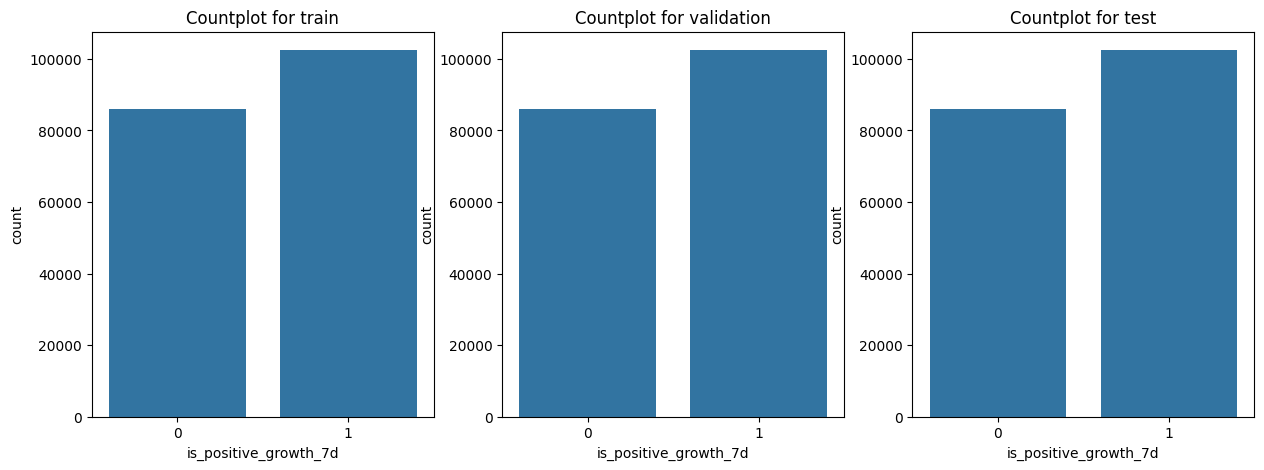

In [113]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes = axes.flat

for split, ax in zip(["train","validation","test"],axes):
    ax.set_title(f"Countplot for {split}")
    split_filter = general_df_split["split"] == split
    sns.countplot(data=general_df,
              x="is_positive_growth_7d", ax=ax)

Although there are a few outliers, the growth feature succeeds in getting a similar distribution of target feature data in all 3 sets.

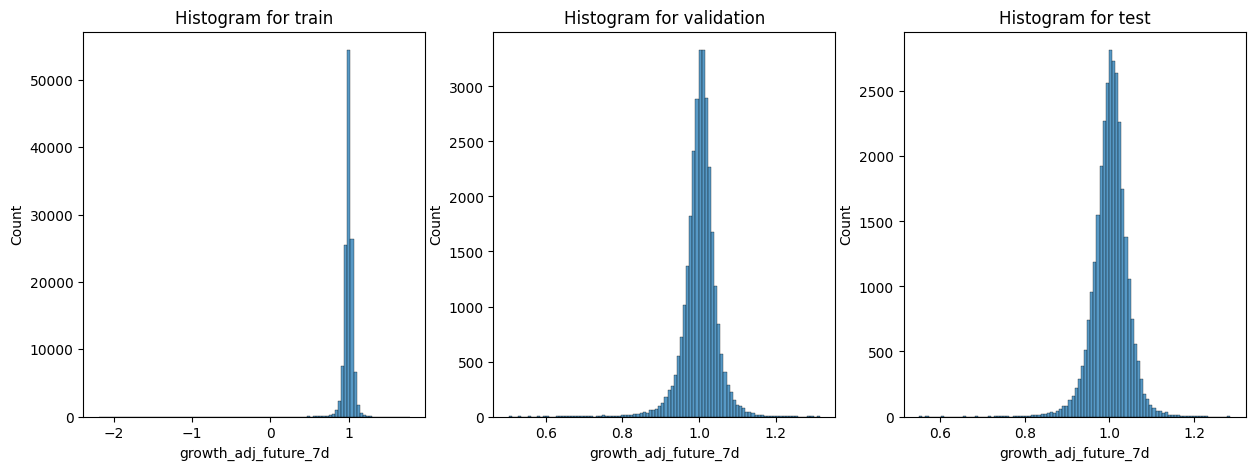

In [114]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes = axes.flat

for split, ax in zip(["train","validation","test"],axes):
    ax.set_title(f"Histogram for {split}")
    split_filter = general_df_split["split"] == split
    sns.histplot(data=general_df_split.loc[split_filter],
                x="growth_adj_future_7d", bins=100, ax=ax)

Macroindicators

In [115]:
general_df.select_dtypes("object")

symbol        country      region                         industry  \
3490     MSFT  united_states  US_AMERICA          software-infrastructure   
3491     MSFT  united_states  US_AMERICA          software-infrastructure   
3492     MSFT  united_states  US_AMERICA          software-infrastructure   
3493     MSFT  united_states  US_AMERICA          software-infrastructure   
3494     MSFT  united_states  US_AMERICA          software-infrastructure   
...       ...            ...         ...                              ...   
226949    ACN        ireland          EU  information-technology-services   
226950    ACN        ireland          EU  information-technology-services   
226951    ACN        ireland          EU  information-technology-services   
226952    ACN        ireland          EU  information-technology-services   
226953    ACN        ireland          EU  information-technology-services   

            sector currency  split  
3490    technology      USD  train  
3491    technology      USD  train  
3492    technology      USD  train  
3493    technology      USD  train  
3494    technology      USD  train  
...            ...      ...    ...  
226949  technology      USD   test  
226950  technology      USD   test  
226951  technology      USD   test  
226952  technology      USD   test  
226953  technology      USD   test  

[188487 rows x 7 columns]

In [116]:
stocks_filter = general_df["symbol"].isin(['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM'])
general_df_aggregated = general_df.loc[stocks_filter].drop(columns=general_df.select_dtypes("object").columns).groupby("date").mean()

This below should be replaced by the SNP500

In [117]:
# general_df_aggregated.close.plot.line()

# Dynamic visualisation of VIX volatility
fig = px.line(general_df_aggregated,
              x=general_df_aggregated.index,
              y="close",
              title='stocks over time')

fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [118]:
# Dynamic visualisation of VIX volatility
fig = px.line(general_df_aggregated,
              x=general_df_aggregated.index,
              y="SMA20",
              title='stocks over time')

fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [119]:
# general_df_aggregated.close.plot.line()

# Dynamic visualisation of VIX volatility
fig = px.line(general_df_aggregated,
              x=general_df_aggregated.index,
              y="CPILFESL",
              title='CPI over time')

fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [120]:
# general_df_aggregated.close.plot.line()

# Dynamic visualisation of VIX volatility
fig = px.line(general_df_aggregated,
              x=general_df_aggregated.index,
              y="growth_adj_30d",
              title='VIX over time')

fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [121]:
correlations_market = general_df_aggregated.corr(numeric_only=True)

In [122]:
pd.set_option("display.max_rows",None)
display(correlations_market.loc[:,"close"].sort_values())
pd.set_option("display.max_rows",40)

volume                      -0.525362
eur_yld_Y10_prev_2d         -0.358382
natr                        -0.229286
eur_yld_Y5_prev_2d          -0.226173
high_minus_low_relative     -0.206088
DGS10_prev_1d               -0.189325
gdppot_us_yoy               -0.187687
gdppot_us_qoq               -0.152553
ht_sine_leadsine            -0.121087
VIX_close                   -0.115324
BTC_growth_adj_365d         -0.108948
aroon_1                     -0.083066
cdlhikkake                  -0.045357
ht_sine_sine                -0.041677
cdlshootingstar             -0.038812
month_sin                   -0.034718
cdlstalledpattern           -0.032151
cdlhikkakemod               -0.030169
cdlinvertedhammer           -0.028267
cdlmatchinglow              -0.025845
quarter_sin                 -0.023905
cdl2crows                   -0.022307
March                       -0.021282
cdlgapsidesidewhite         -0.021158
DGS5_prev_1d                -0.018908
cdlhighwave                 -0.018905
BTC_growth_a

In [123]:
pd.set_option("display.max_rows",None)
display(correlations_market.loc[:,"growth_adj_30d"].sort_values())
pd.set_option("display.max_rows",40)

ht_sine_leadsine            -0.604821
aroon_1                     -0.600189
high_minus_low_relative     -0.367443
VIX_close                   -0.360928
natr                        -0.359645
volume                      -0.131809
minus_di                    -0.130229
cdlinvertedhammer           -0.087332
cdldojistar                 -0.082753
ht_sine_sine                -0.076358
crude_oil_growth_adj_365d   -0.062614
gdppot_us_yoy               -0.062347
DGS10_prev_1d               -0.060964
cdladvancedblock            -0.060475
October                     -0.059491
cpi_core_mom_prev_month     -0.058909
gdppot_us_qoq               -0.058414
cdlhangingman               -0.053919
brent_oil_growth_adj_365d   -0.052788
cpi_core_yoy_prev_month     -0.050549
DGS5_prev_1d                -0.047122
August                      -0.046890
July                        -0.039048
eur_yld_Y10_prev_2d         -0.037032
is_positive_growth_7d       -0.036901
cdlcounterattack            -0.036513
gold_growth_

Correlations to check if they are correlated due to being the stock's close price lagged indicator:
- atr
- dm
- minus_di
- CPIFESL
- cpi_core_yoy_prev_month
- ^GSPC_growth_adj_365d 
- apo          
- macd_ext                         
- macdsignal_ext
- EPI_growth_adj_365d               
- ^GSPC_growth_adj_90d            
- FEDFUNDS_prev_month            
- ht_phasor_inphase            
- ^DJI_growth_adj_365d         
- DGS1_prev_1d
negative:
- eur_yld_Y10_prev_2d
- gdppot_us_yoy    
- volume
- high_minus_low_relative       
- VIX_close                                                      

In [124]:
pd.set_option("display.max_rows",None)
display(correlations_market.loc[:,"growth_adj_future_7d"].sort_values())
pd.set_option("display.max_rows",40)

gdppot_us_yoy               -0.088665
DGS10_prev_1d               -0.088547
gdppot_us_qoq               -0.084592
DGS5_prev_1d                -0.081490
brent_oil_growth_adj_365d   -0.070737
volume                      -0.067088
natr                        -0.066648
crude_oil_growth_adj_365d   -0.065961
high_minus_low_relative     -0.056255
fastk_rsi                   -0.050946
cdlclosingmarubozu          -0.050687
fastk                       -0.050500
fastd_rsi                   -0.049648
^GSPC_growth_adj_1d         -0.048246
September                   -0.048082
growth_adj_3d               -0.047851
growth_adj_7d               -0.046661
growth_adj_1d               -0.046587
DGS1_prev_1d                -0.045724
^DJI_growth_adj_1d          -0.043994
slowk                       -0.043600
fastd                       -0.043489
^GSPC_growth_adj_3d         -0.043051
^GSPC_growth_adj_7d         -0.042607
^DJI_growth_adj_7d          -0.040838
eur_yld_Y5_prev_2d          -0.040316
bop         

In [125]:
pd.set_option("display.max_rows",None)
display(correlations_market.loc[:,"growth_adj_future_7d"].sort_values())
pd.set_option("display.max_rows",40)

gdppot_us_yoy               -0.088665
DGS10_prev_1d               -0.088547
gdppot_us_qoq               -0.084592
DGS5_prev_1d                -0.081490
brent_oil_growth_adj_365d   -0.070737
volume                      -0.067088
natr                        -0.066648
crude_oil_growth_adj_365d   -0.065961
high_minus_low_relative     -0.056255
fastk_rsi                   -0.050946
cdlclosingmarubozu          -0.050687
fastk                       -0.050500
fastd_rsi                   -0.049648
^GSPC_growth_adj_1d         -0.048246
September                   -0.048082
growth_adj_3d               -0.047851
growth_adj_7d               -0.046661
growth_adj_1d               -0.046587
DGS1_prev_1d                -0.045724
^DJI_growth_adj_1d          -0.043994
slowk                       -0.043600
fastd                       -0.043489
^GSPC_growth_adj_3d         -0.043051
^GSPC_growth_adj_7d         -0.042607
^DJI_growth_adj_7d          -0.040838
eur_yld_Y5_prev_2d          -0.040316
bop         

In [126]:
pd.set_option("display.max_rows",None)
display(correlations_market.loc[:,"growth_adj_future_30d"].sort_values())
pd.set_option("display.max_rows",40)

brent_oil_growth_adj_365d   -0.180828
gdppot_us_yoy               -0.175493
DGS10_prev_1d               -0.172810
gdppot_us_qoq               -0.168312
DGS5_prev_1d                -0.160966
crude_oil_growth_adj_365d   -0.144571
natr                        -0.130516
high_minus_low_relative     -0.115503
volume                      -0.106340
DGS1_prev_1d                -0.093392
eur_yld_Y5_prev_2d          -0.088007
eur_yld_Y10_prev_2d         -0.082039
gold_growth_adj_365d        -0.074500
FEDFUNDS_prev_month         -0.071987
September                   -0.068056
eur_yld_Y1_prev_2d          -0.067722
ht_trendmod                 -0.066509
EPI_growth_adj_365d         -0.065115
cpi_core_yoy_prev_month     -0.052470
cpi_core_mom_prev_month     -0.052457
July                        -0.048721
adxr                        -0.037385
^DJI_growth_adj_30d         -0.035242
gold_growth_adj_7d          -0.030664
^DJI_growth_adj_1d          -0.030134
January                     -0.029862
cdlhikkake  

In [127]:
pd.set_option("display.max_rows",None)
display(correlations_market.loc[:,"SMA20"].sort_values())
pd.set_option("display.max_rows",40)

volume                      -0.524118
eur_yld_Y10_prev_2d         -0.359523
eur_yld_Y5_prev_2d          -0.227233
natr                        -0.224731
high_minus_low_relative     -0.198962
DGS10_prev_1d               -0.189588
gdppot_us_yoy               -0.187596
gdppot_us_qoq               -0.152112
ht_sine_leadsine            -0.115654
BTC_growth_adj_365d         -0.113853
VIX_close                   -0.106600
aroon_1                     -0.065848
ht_sine_sine                -0.049997
cdlhikkake                  -0.045327
cdlshootingstar             -0.037604
month_sin                   -0.035781
cdlstalledpattern           -0.030604
cdlhikkakemod               -0.030269
macdhist                    -0.027447
macdhist_fix                -0.027433
cdlmatchinglow              -0.025407
cdlinvertedhammer           -0.025305
macdhist_ext                -0.025046
quarter_sin                 -0.024497
BTC_growth_adj_90d          -0.023899
BTC_growth_adj_30d          -0.023282
cdl2crows   

Correlation of macroindicators

Plot cycle indicators for some stocks

In [128]:
# general_df_aggregated.close.plot.line()

# Dynamic visualisation of VIX volatility
fig = px.line(general_df_aggregated,
              x=general_df_aggregated.index,
              y="growth_adj_30d",
              title='VIX over time')

fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [129]:
# general_df_aggregated.close.plot.line()

# Dynamic visualisation of VIX volatility
fig = px.line(general_df_aggregated,
              x=general_df_aggregated.index,
              y="ht_dcperiod",
              title='HT dcperiod over time')

fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [130]:
# general_df_aggregated.close.plot.line()

# Dynamic visualisation of VIX volatility
fig = px.line(general_df_aggregated,
              x=general_df_aggregated.index,
              y="ht_dcphase",
              title='HT dcperiod over time')

fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## Modelling

Regression

**Classification**

Models:
- Random Forest
- XGBoost
- NN

Variant:
- Including fees
- Not including fees
- Shorting too
- Grows more than x%

**Generate new features**

In [131]:
general_df["ln_volume"] = np.log(general_df["volume"]).replace(-np.inf,0)
general_df = pd.concat([general_df,pd.get_dummies(general_df["symbol"],prefix="symbol").astype(int)],axis=1)
general_df = pd.concat([general_df,pd.get_dummies(general_df["weekday"].astype(int),prefix="weekday").astype(int)],axis=1)

/home/miguel/data_science/algorithmic_trading/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log



In [132]:
stocks = {
    # https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
    "US": ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM'],

    # https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
    "EU": ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA'],

    # https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
    "INDIA": ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS'],
    }

general_df["country_US"] = np.where(general_df["symbol"].isin(stocks["US"]), 1, 0)
general_df["country_EU"] = np.where(general_df["symbol"].isin(stocks["EU"]), 1, 0)
general_df["country_INDIA"] = np.where(general_df["symbol"].isin(stocks["INDIA"]), 1, 0)

**Features to drop**

In [133]:
target_not_used = ["growth_adj_future_7d","growth_adj_future_30d","is_positive_growth_30d"]
feat_not_used = ['Date_x', 
                 'close',
                    'high',
                    'low',
                    'open',
                    'volume',
                    'symbol',
                    'year',
                    'month',
                    'weekday',
                    'quarter_n',
                    'quarter',
                    'month_dt',
                    'date',
                    'Date_y',
                    'Date']

feat_to_drop = target_not_used + feat_not_used

In [134]:
general_df["is_positive_growth_7d"]

3490      0
3491      0
3492      0
3493      0
3494      1
         ..
226949    0
226950    0
226951    0
226952    0
226953    0
Name: is_positive_growth_7d, Length: 188487, dtype: int64

In [135]:
general_df.dropna(subset="growth_adj_future_7d",inplace=True)

**Train-validation-test split**

In [136]:
date = general_df["Date"]

general_df = general_df.drop(columns=feat_to_drop)

In [137]:
object_columns = general_df.select_dtypes("object").columns.to_list()

general_df_train = general_df.loc[general_df["split"] == "train"].copy(deep=True)
general_df_val = general_df.loc[general_df["split"] == "validation"].copy(deep=True)

general_df_train_final = general_df.loc[general_df["split"].isin(["train","validation"])].copy(deep=True)
general_df_test = general_df.loc[general_df["split"] == "test"].copy(deep=True)

y_train, X_train = general_df_train["is_positive_growth_7d"], general_df_train.drop(columns= object_columns+ ["is_positive_growth_7d"]) # clean this mess
y_val, X_val = general_df_val["is_positive_growth_7d"], general_df_val.drop(columns=object_columns+ ["is_positive_growth_7d"])

y_train_final, X_train_final = general_df_train_final["is_positive_growth_7d"], general_df_train_final.drop(columns=object_columns+ ["is_positive_growth_7d"])
y_test, X_test = general_df_test["is_positive_growth_7d"], general_df_test.drop(columns=object_columns+ ["is_positive_growth_7d"])

Fill missing

In [138]:
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_train_final = X_train_final.fillna(0)
X_train = X_train.fillna(0)

**Model**

**XGboost**

In [139]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, accuracy_score, f1_score, recall_score

In [140]:
clf_xgb = XGBClassifier(
    tree_method='hist',
    device="cuda",
)

In [141]:
clf_xgb.fit(X_train_final, y_train_final)
y_probs = clf_xgb.predict_proba(X_test)[:,1]
y_pred = clf_xgb.predict(X_test)
print(y_probs)

[0.60197693 0.628049   0.7200594  ... 0.3161206  0.2959002  0.13290024]


In [142]:
y_probs.shape

(30682,)

In [143]:
y_pred = (y_probs > 0.01).astype(int)

In [144]:
y_pred = (y_probs > 0.01).astype(int)


precisiones = {"prob": [], "precision": []}
for prob in np.arange(0.01,1,0.01):
    y_pred = (y_probs > prob).astype(int)
    precisiones["prob"].append(prob)
    precision = precision_score(y_test, y_pred)
    precisiones["precision"].append(precision)
    if precision == 0:
        print(f"La prob {prob} da problemas")

precisiones_df = pd.DataFrame(precisiones)

La prob 0.97 da problemas
La prob 0.98 da problemas
La prob 0.99 da problemas


/home/miguel/data_science/algorithmic_trading/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/miguel/data_science/algorithmic_trading/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/miguel/data_science/algorithmic_trading/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [145]:
precisiones_df.tail(20)

prob  precision
79  0.80   0.587831
80  0.81   0.576404
81  0.82   0.576873
82  0.83   0.588509
83  0.84   0.602210
84  0.85   0.600887
85  0.86   0.620419
86  0.87   0.600671
87  0.88   0.637168
88  0.89   0.654545
89  0.90   0.623932
90  0.91   0.593023
91  0.92   0.686275
92  0.93   0.645161
93  0.94   0.555556
94  0.95   0.428571
95  0.96   0.500000
96  0.97   0.000000
97  0.98   0.000000
98  0.99   0.000000

In [146]:
y_pred = (y_probs > 0.85).astype(int)

In [147]:
y_pred.sum()

451

In [148]:
recall_score(y_test, y_pred)

0.016083086053412462

In [149]:
accuracy_score(y_test, y_pred)

0.4537839775764292

In [150]:
f1_score(y_test, y_pred, average="macro")

0.3254929427826109

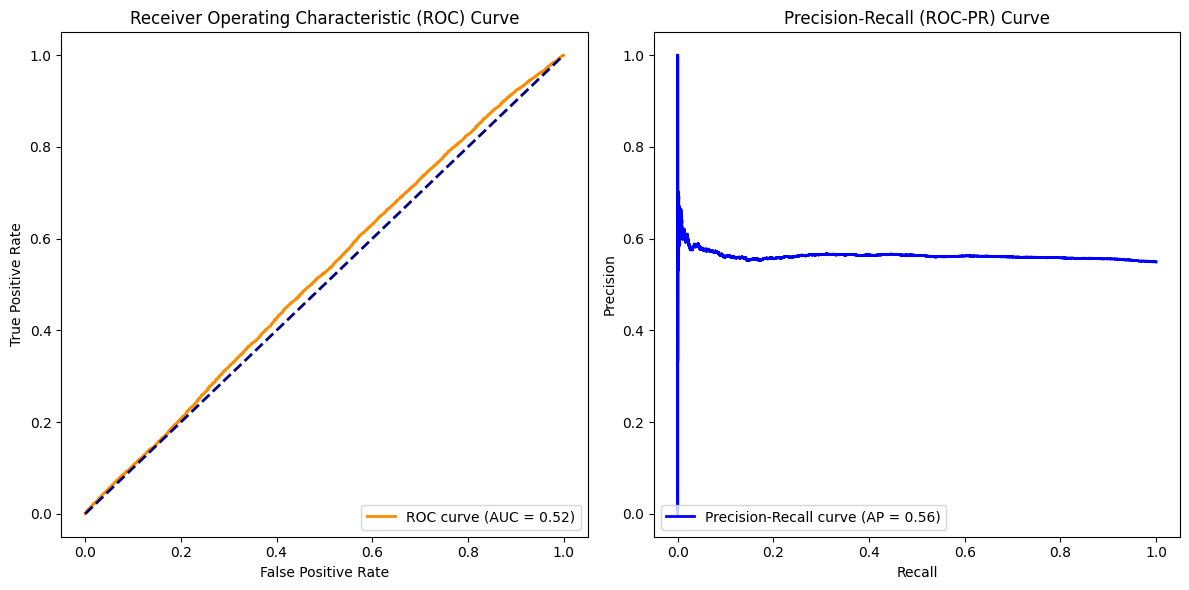

In [151]:
y_true = y_test
y_proba = y_probs


# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_proba)
average_precision = average_precision_score(y_true, y_proba)

# Plot ROC Curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot ROC-PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (ROC-PR) Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


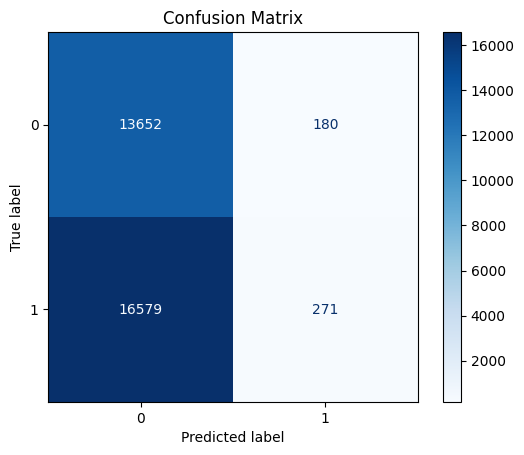

In [152]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
disp.plot(cmap=plt.cm.Blues)

# Customize plot
plt.title("Confusion Matrix")
plt.show()


In [153]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report

In [154]:
fraccion_positivos, media_prob_predicha = calibration_curve(y_test, y_probs, n_bins=20)

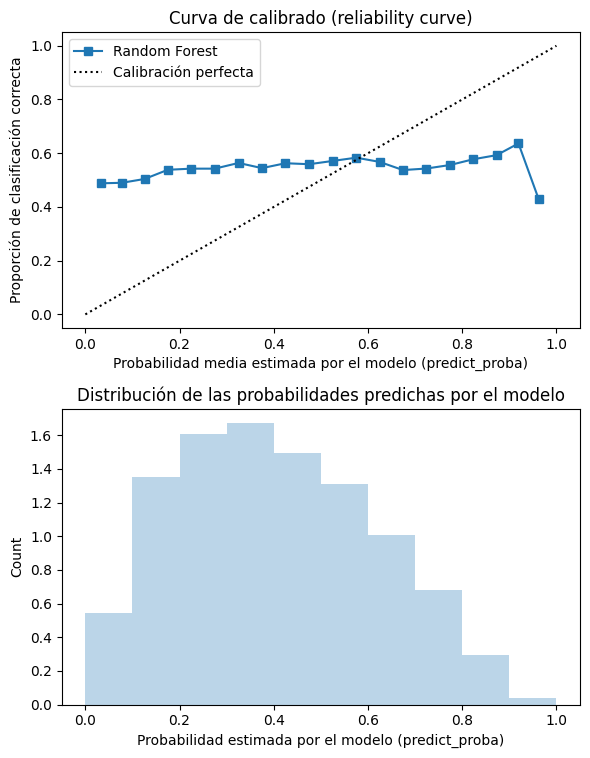

In [155]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))

axs[0].plot(media_prob_predicha, fraccion_positivos, "s-", label="Random Forest")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

axs[1].hist(y_probs, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

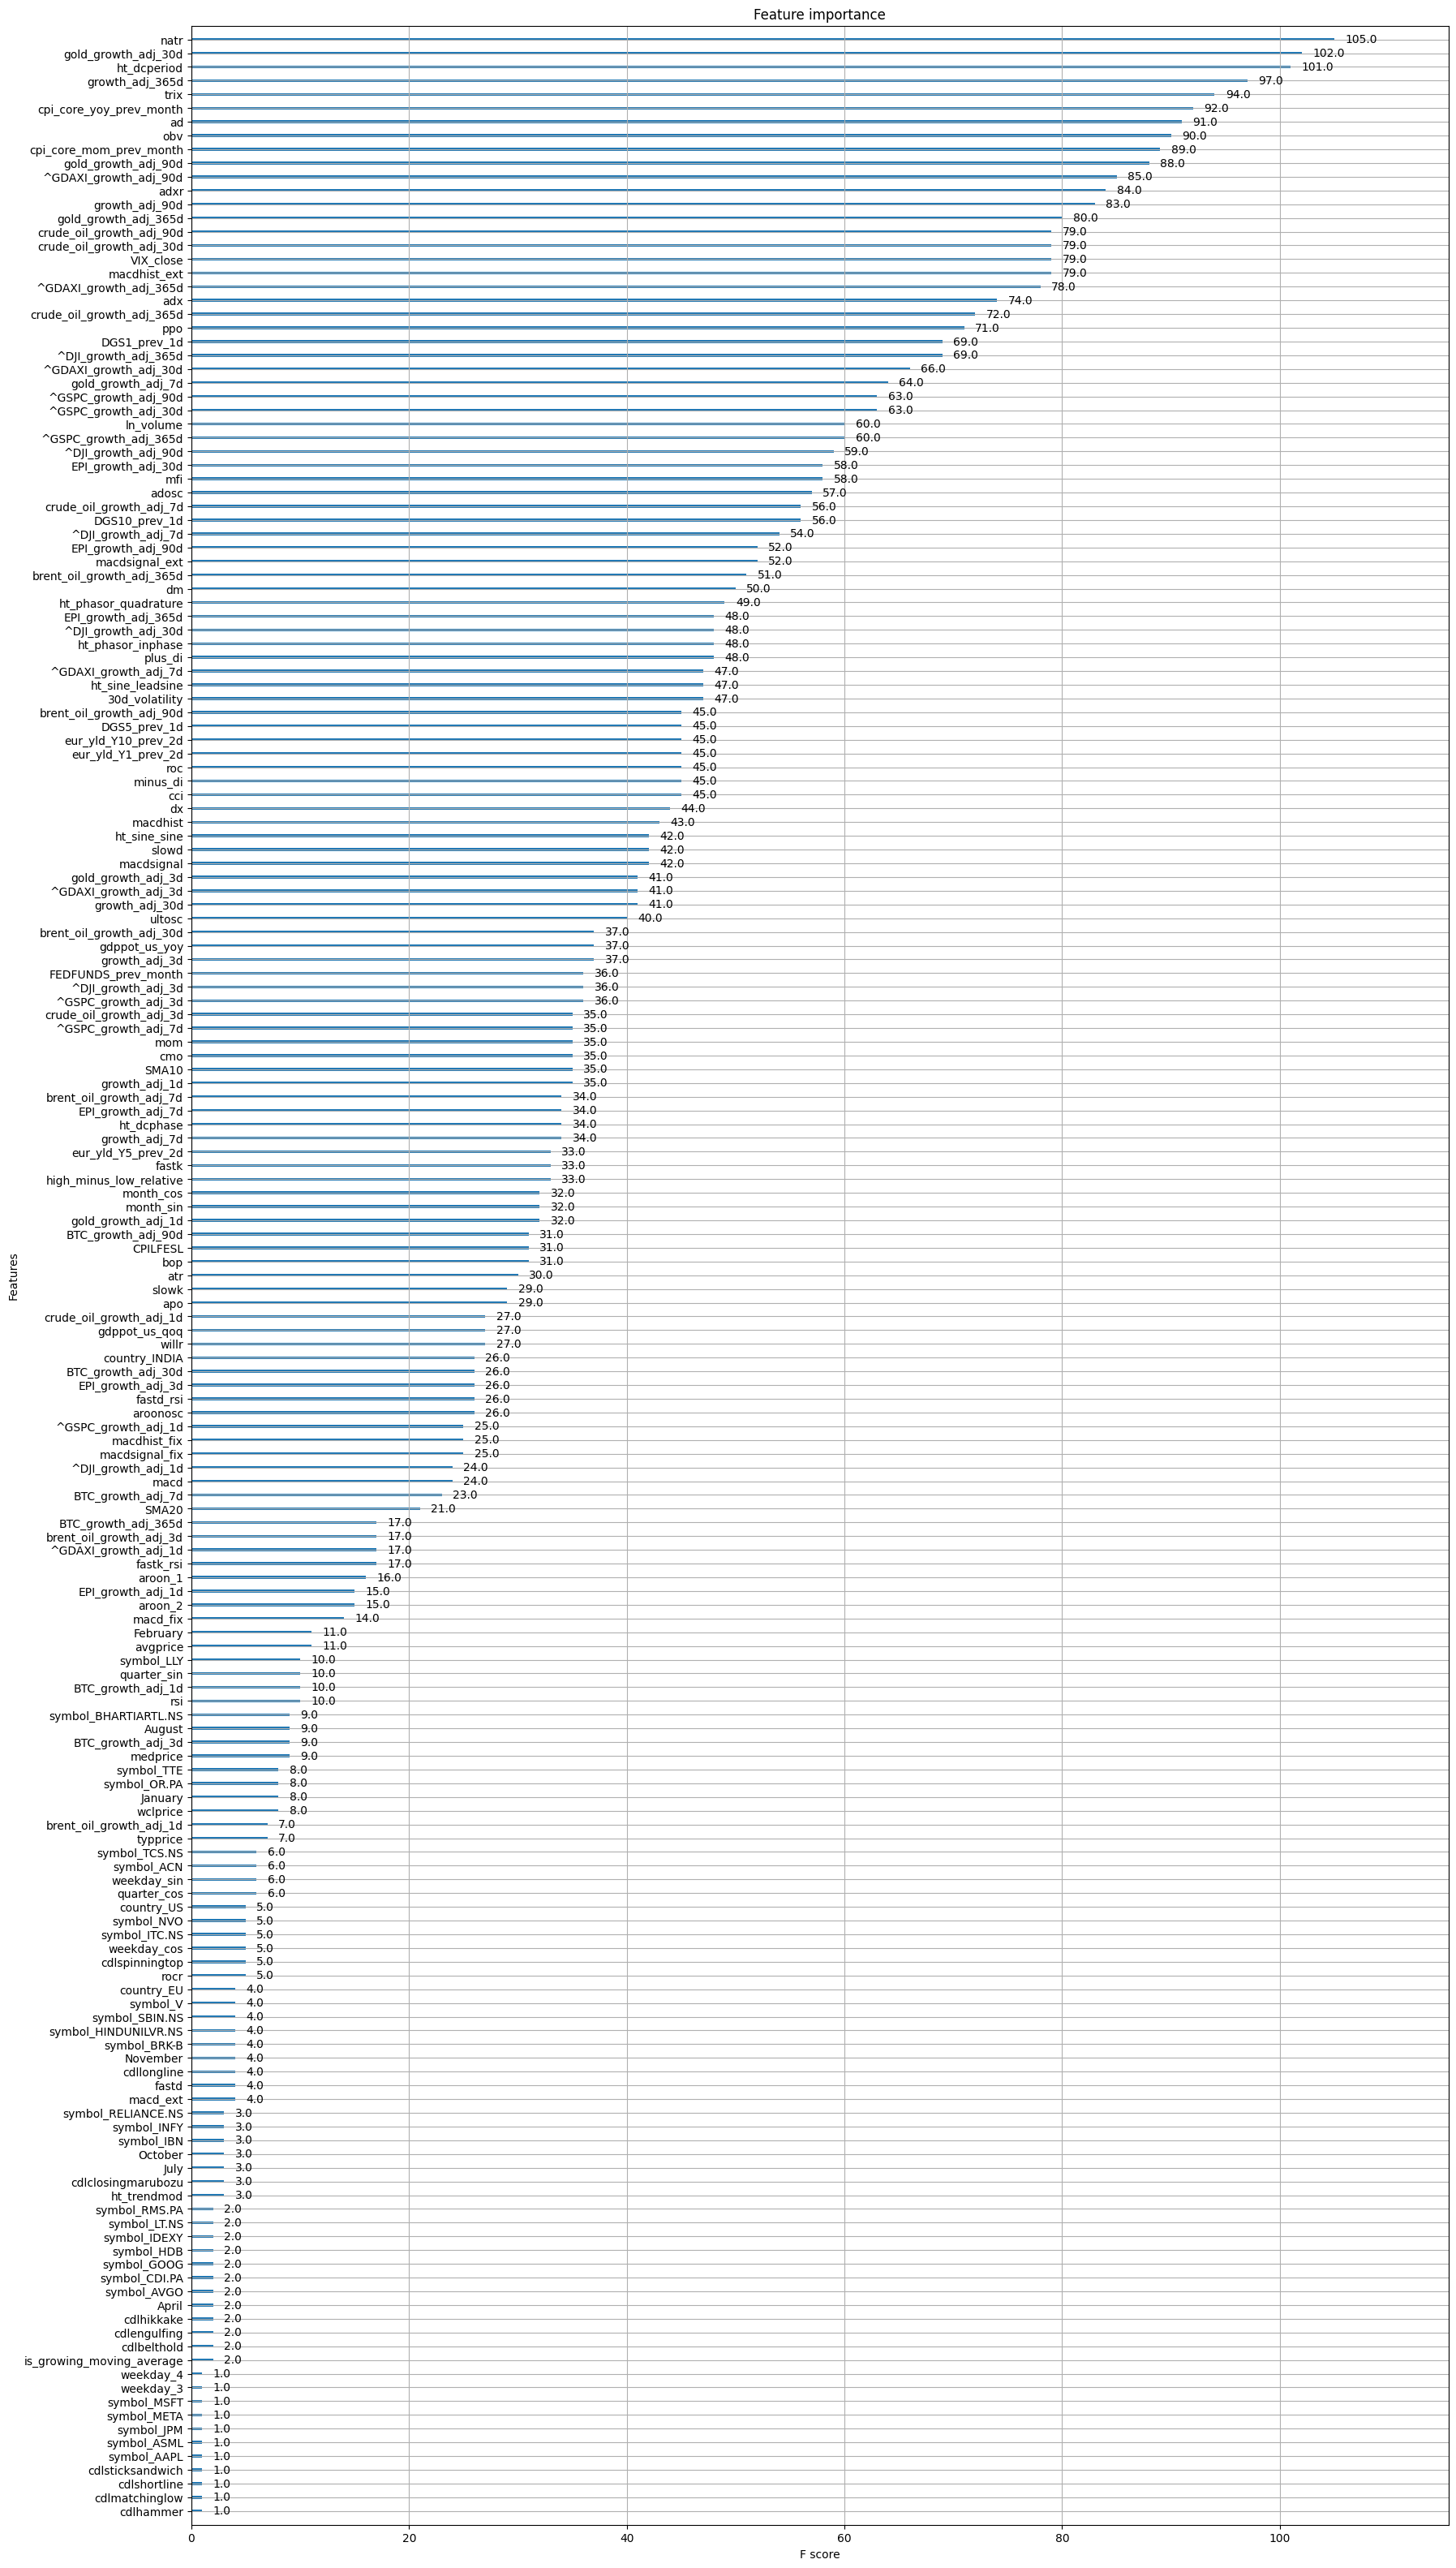

In [156]:
import matplotlib.pyplot as plt
from xgboost import plot_importance


fig, ax = plt.subplots(figsize=(20, 40))

# Plot importance on our axes
plot_importance(clf_xgb, ax=ax, importance_type='weight')

plt.show()

In [157]:
import joblib
import os

os.makedirs(name="../model/",exist_ok=True)
joblib.dump(clf_xgb, "../model/mock_model.joblib")

['../model/mock_model.joblib']

In [158]:
general_df_test.columns.to_list()

['country',
 'region',
 'industry',
 'sector',
 'currency',
 'growth_adj_1d',
 'growth_adj_3d',
 'growth_adj_7d',
 'growth_adj_30d',
 'growth_adj_90d',
 'growth_adj_365d',
 'SMA10',
 'SMA20',
 'is_growing_moving_average',
 'high_minus_low_relative',
 '30d_volatility',
 'is_positive_growth_7d',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'ht_dcperiod',
 'ht_dcphase',
 'ht_phasor_inphase',
 'ht_phasor_quadrature',
 'ht_sine_sine',
 'ht_sine_leadsine',
 'ht_trendmod',
 'avgprice',
 'medprice',
 'typprice',
 'wclprice',
 'cdl2crows',
 'cdl3blackrows',
 'cdl3inside',
 'cd

In [161]:
general_df["date"] = date
mock_data = general_df[general_df["date"] == general_df["date"].max()].drop(columns=["is_positive_growth_7d"])

mock_data.to_parquet("../src/predict/mock_data.parquet")

In [139]:
mock_data.to_dict(orient="records")

[{'close': 417.1900024414063,
  'high': 418.5,
  'low': 412.2900085449219,
  'open': 415.239990234375,
  'volume': 17604800.0,
  'symbol': 'MSFT',
  'year': 2025,
  'month': 1,
  'weekday': 0,
  'quarter_n': 1,
  'quarter': Timestamp('2025-01-01 00:00:00'),
  'month_dt': Timestamp('2025-01-01 00:00:00'),
  'growth_adj_1d': 0.995798998175574,
  'growth_adj_3d': 0.9877358885913664,
  'growth_adj_7d': 0.9854493833156976,
  'growth_adj_30d': 0.9353616714891632,
  'growth_adj_90d': 1.020718511216196,
  'growth_adj_365d': 1.098073811895102,
  'SMA10': 422.9709991455078,
  'SMA20': 432.8149978637695,
  'is_growing_moving_average': 0,
  'high_minus_low_relative': 0.014885283488906973,
  '30d_volatility': 173.81857988842546,
  'growth_adj_future_7d': 1.0251745674658812,
  'is_positive_growth_7d': 1,
  'growth_adj_future_30d': nan,
  'is_positive_growth_30d': 0,
  'Date_x': Timestamp('2025-01-13 00:00:00+0000', tz='UTC'),
  'adx': 22.24213855883946,
  'adxr': 24.157737747060686,
  'apo': -9.7214

In [162]:
pd.DataFrame(mock_data.to_dict(orient="records"))

country      region                         industry  \
0   united_states  US_AMERICA          software-infrastructure   
1           india        ASIA                   banks-regional   
2           india        ASIA         engineering-construction   
3           india        ASIA                   insurance-life   
4           india        ASIA                 telecom-services   
5           india        ASIA      household-personal-products   
6           india        ASIA       oil-gas-refining-marketing   
7           india        ASIA  information-technology-services   
8           india        ASIA                          tobacco   
9          france          EU                     luxury-goods   
10         france          EU      household-personal-products   
11         france          EU                     luxury-goods   
12         france          EU                     luxury-goods   
13        germany          EU   specialty-industrial-machinery   

                    sector currency  growth_adj_1d  growth_adj_3d  \
0               technology      USD       0.995799       0.987736   
1       financial-services      INR       0.981500       0.945990   
2              industrials      INR       0.979681       0.963282   
3       financial-services      INR       0.963609       0.931005   
4   communication-services      INR       0.988427       0.998749   
5       consumer-defensive      INR       1.003665       1.020825   
6                   energy      INR       0.998349       0.979731   
7               technology      INR       1.005966       1.044470   
8       consumer-defensive      INR       0.986851       0.976643   
9        consumer-cyclical      EUR       0.999174       1.008333   
10      consumer-defensive      EUR       1.003054       0.990798   
11       consumer-cyclical      EUR       0.994085       0.992827   
12       consumer-cyclical      EUR       1.002171       1.016832   
13             industrials      EUR       0.993213       0.998140   

    growth_adj_7d  growth_adj_30d  growth_adj_90d  ...  weekday_1  weekday_2  \
0        0.985449        0.935362        1.020719  ...          0          0   
1        0.939593        0.846681        0.933521  ...          0          0   
2        0.961451        0.884483        0.980721  ...          0          0   
3        0.923617        0.861685        0.838812  ...          0          0   
4        1.005509        1.007062        0.963649  ...          0          0   
5        1.031479        1.020676        0.872981  ...          0          0   
6        1.017939        0.969997        0.887287  ...          0          0   
7        1.047888        0.969203        1.011360  ...          0          0   
8        0.991867        0.943686        0.864357  ...          0          0   
9        1.012552        1.001656        0.988826  ...          0          0   
10       0.971598        0.939091        0.848798  ...          0          0   
11       1.006416        1.032924        1.094928  ...          0          0   
12       1.018594        0.990500        0.995357  ...          0          0   
13       1.000518        1.000622        1.056321  ...          0          0   

    weekday_3  weekday_4  weekday_5  weekday_6  country_US  country_EU  \
0           0          0          0          0           1           0   
1           0          0          0          0           0           0   
2           0          0          0          0           0           0   
3           0          0          0          0           0           0   
4           0          0          0          0           0           0   
5           0          0          0          0           0           0   
6           0          0          0          0           0           0   
7           0          0          0          0           0           0   
8           0          0          0          0           0           0   
9           0          0          0       

In [163]:
np.array(mock_data.to_dict(orient="records").values())

AttributeError: 'list' object has no attribute 'values'